###### The probability of an eccentricity GIVEN that a planet is transiting (P(e|b)) and the probability of a longitude of periastron GIVEN that a planet is transiting (P(w|b)) are different than P(e) and P(w).

https://academic.oup.com/mnras/article/444/3/2263/1053015

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
from scipy.stats import rayleigh
import os

from pathlib import Path

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# UNIFORM DISTRIBUTION

In [246]:
trueew_uniform = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/uniform/fitew.txt', index_col=False)

In [247]:
distpath_uniform = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/uniform/edists/"

paths = sorted(Path(distpath_uniform).iterdir(), key=os.path.getmtime)
paths.reverse()

In [248]:
edist_uniform = []

for file in paths:
    fname = os.path.join(distpath_uniform, file)
    try:
        edist_uniform.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass

es_uniform = []
ws_uniform = []
gs_uniform = []

for i in range(len(edist_uniform)):

    es_uniform.append(edist_uniform[i][:,0])
    ws_uniform.append(edist_uniform[i][:,1])
    gs_uniform.append(edist_uniform[i][:,2])

Text(0.5, 0, 'Fit E Distributions')

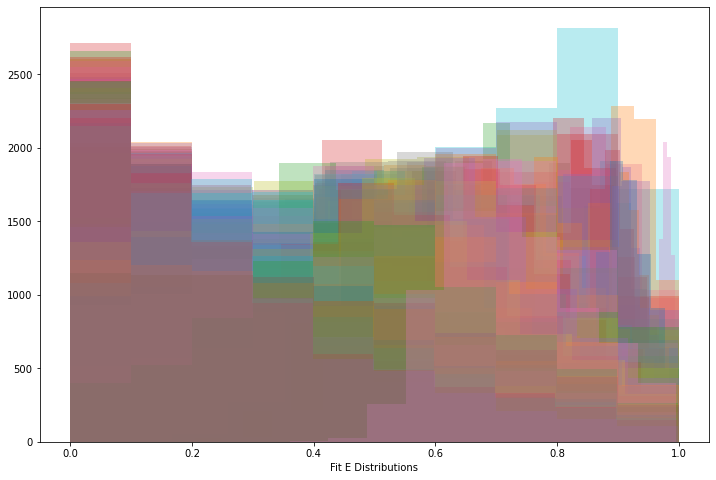

In [249]:
es_uniform = np.array(es_uniform)

plt.cla()

for i in range(len(es_uniform)):
    plt.hist(es_uniform[i], alpha=0.3)
    
plt.xlabel('Fit E Distributions')

Text(0.5, 0, 'Fit w Distributions')

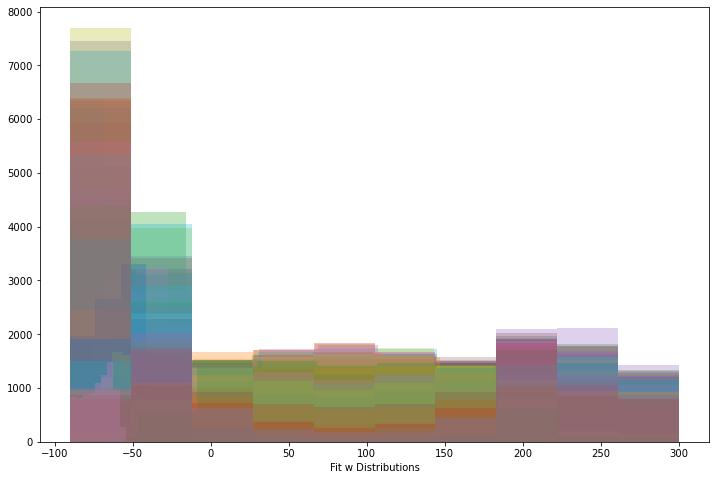

In [250]:
ws_uniform = np.array(ws_uniform)

plt.cla()

for i in range(len(es_uniform)):
    plt.hist(ws_uniform[i], alpha=0.3)
    
plt.xlabel('Fit w Distributions')

In [251]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [252]:
len(trueew_uniform['truew'])

318

In [328]:
wuniform = np.random.uniform(-90, 90, 50)

inds = []

for i in range(len(wuniform)):
    inds.append(int(np.where(trueew_uniform['fitw'] == find_nearest(trueew_uniform['fitw'], wuniform[i]))[0]))

euni = trueew_uniform['truee'][inds]
wuni = trueew_uniform['truew'][inds]

efuni = trueew_uniform['fite'][inds]
wfuni = trueew_uniform['fitw'][inds]
    
edistuni = es_uniform[inds].flatten()
wdistuni = ws_uniform[inds].flatten()

(array([4., 7., 8., 4., 6., 5., 6., 2., 3., 5.]),
 array([-89.78412694, -72.17420035, -54.56427376, -36.95434716,
        -19.34442057,  -1.73449397,  15.87543262,  33.48535921,
         51.09528581,  68.7052124 ,  86.315139  ]),
 <BarContainer object of 10 artists>)

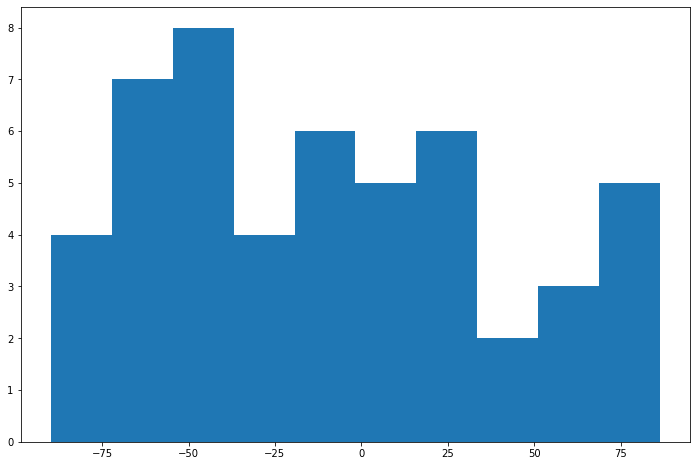

In [329]:
plt.hist(wuniform)

Text(0, 0.5, 'ECCENTRICITY')

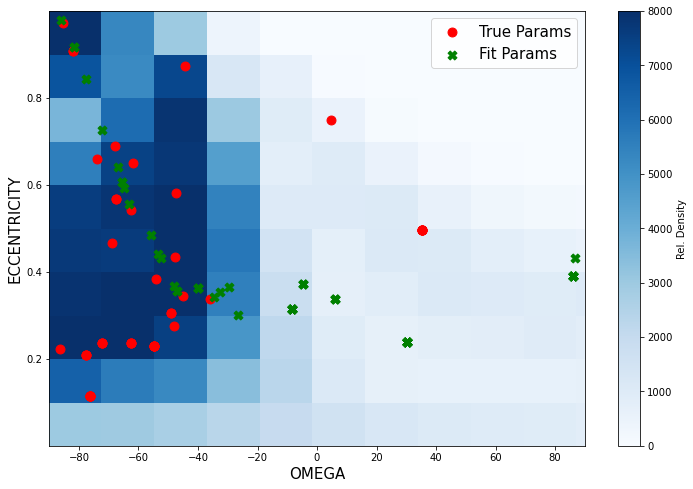

In [360]:
plt.cla()

fz = 15

plt.hist2d(wdistuni, edistuni, bins=[22,10], cmap='Blues');
plt.xlim(-90, 90)
plt.clim(vmax=8000.0)
plt.colorbar(label='Rel. Density')
plt.scatter(wuni, euni, marker='o', s=80, c='red', label='True Params')
plt.scatter(wfuni, efuni, marker='X', s=80, c='green', label='Fit Params')

plt.legend(fontsize=fz)

plt.xlabel('OMEGA', fontsize=fz)
plt.ylabel('ECCENTRICITY', fontsize=fz)

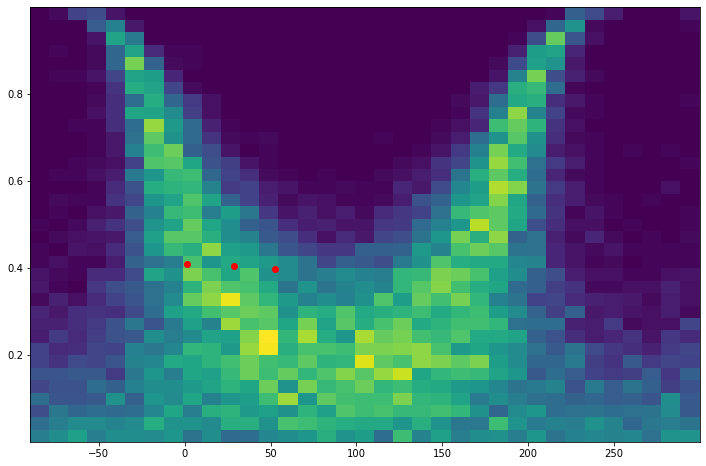

In [163]:
plt.hist2d(np.array(wdist).flatten(), np.array(edist).flatten(), bins=35)
plt.scatter(ws, es, c='r')

# GAUSSIAN DISTRIBUTION

In [219]:
# e_rand = np.random.normal(0.4, 0.1, size=n)
# w_rand = np.random.normal(0.0, 45.0, size=n)

In [230]:
trueew_gauss = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/gaussian/fnames.txt', index_col=False)

truee_gauss = np.array(trueew_gauss['true_e'])
truew_gauss = np.array(trueew_gauss['true_w'])

distpath_gauss = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/gaussian/edists/"
zscpath_gauss = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/gaussian/zscores/"

edist_gauss = []
zsc_gauss = []

for file in os.listdir(distpath_gauss):
    fname = os.path.join(distpath_gauss, file)
    try:
        edist_gauss.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass
    

for file in os.listdir(zscpath_gauss):
    fname = os.path.join(zscpath_gauss, file)
    try:
        zsc_gauss.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass

es_gauss = []
ws_gauss = []
gs_gauss = []

zsc_e_gauss = []
zsc_w_gauss = []

for i in range(len(edist_gauss)):
    try:
        es_gauss.append(edist_gauss[i][:,0])
        ws_gauss.append(edist_gauss[i][:,1])
        gs_gauss.append(edist_gauss[i][:,2])
        
        zsc_e_gauss.append(zsc_gauss[i][0])
        zsc_w_gauss.append(zsc_gauss[i][1])
        
    except IndexError:
        truee = np.delete(truee_gauss, i)
        truew = np.delete(truew_gauss, i)
    

es_mode_gauss = []
ws_mode_gauss = []
gs_mode_gauss = []

for i in range(len(es_gauss)):
    es_mode_gauss.append(ph.mode(es_gauss[i]))
    ws_mode_gauss.append(ph.mode(ws_gauss[i]))
    gs_mode_gauss.append(ph.mode(gs_gauss[i]))
    

zsc_means_gauss = []

for i in range(len(zsc_e_gauss)):
    zsc_means_gauss.append(np.mean((zsc_e_gauss[i], zsc_w_gauss[i])))

#plt.scatter(truee, truew, c=np.abs(zsc_means), cmap='Blues_r')
#plt.colorbar()

Text(0.5, 0, 'Fit E Distributions')

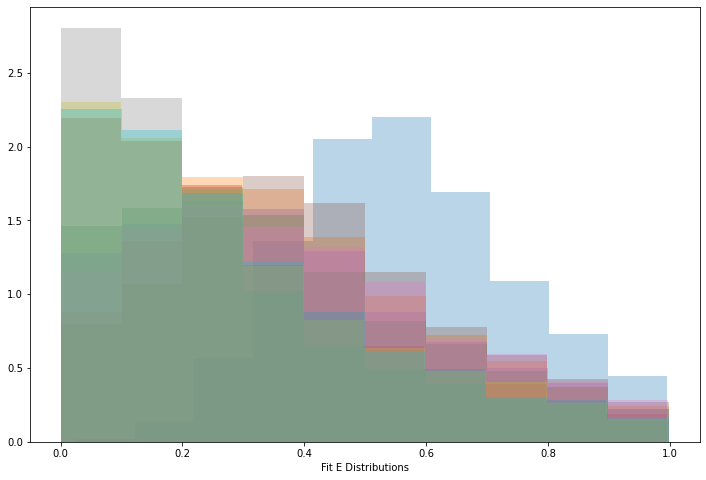

In [231]:
es_gauss = np.array(es_gauss)

plt.cla()

for i in range(len(es_gauss)):
    plt.hist(es_gauss[i], alpha=0.3, density=1.0)
    
plt.xlabel('Fit E Distributions')

Text(0.5, 0, 'Fit w Distributions')

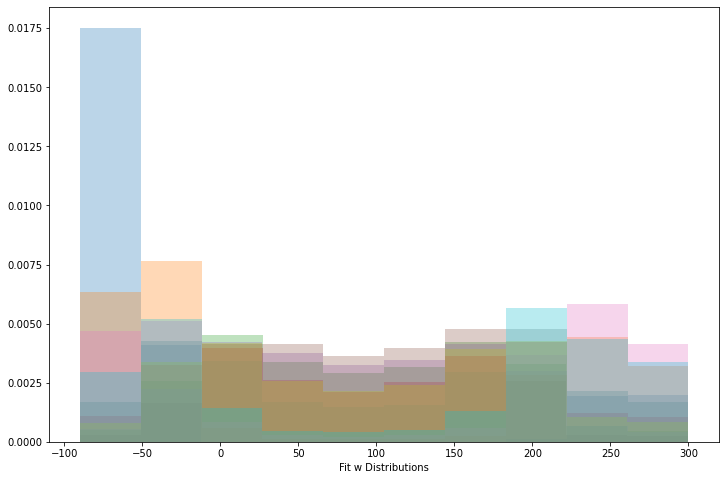

In [232]:
ws_gauss = np.array(ws_gauss)

plt.cla()

for i in range(len(ws_gauss)):
    plt.hist(ws_gauss[i], alpha=0.3, density=1.0)
    
plt.xlabel('Fit w Distributions')

In [233]:
alles_gauss = es_gauss.flatten()
allws_gauss = ws_gauss.flatten()

Text(0, 0.5, 'ECCENTRICITY')

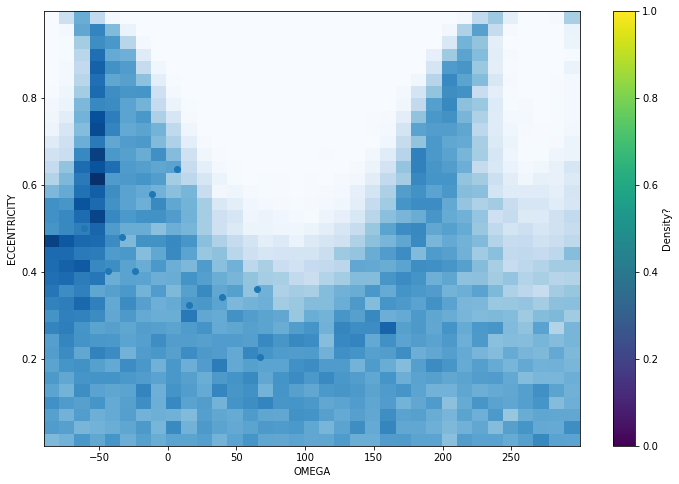

In [235]:
plt.cla()

plt.hist2d(allws_gauss, alles_gauss, bins=35, cmap='Blues');
plt.scatter(truew_gauss, truee_gauss)
#plt.clim(vmax=5000.0)
plt.colorbar(label='Density?')

plt.xlabel('OMEGA')
plt.ylabel('ECCENTRICITY')